In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import plotly.express as px
import pickle

## Open Data and Join Data

In [2]:
data_train = pd.read_csv("data/train.csv")
data_store = pd.read_csv("data/store.csv")
dt = data_train.merge(data_store, left_on='Store', right_on='Store', how="left")

/Users/selbo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Clean Data

In [3]:
dt.Open.fillna(1, inplace=True)
dt.Open.isnull().sum()

#remove all without Store
dt = dt.dropna( how='any', subset=['Store'])
#Make a variable ReOPENING that 1 one if a shop opens after 5 days of absence
#make a variable BIG reopening that is 1 after a shop open after 10 days of absence
dt['Open_5']  = dt.groupby('Store')['Open'].transform(lambda x: x.rolling(5,  min_periods=5).mean())
dt['Open_last5'] = dt.groupby('Store')['Open_5'].shift(1)
dt['Open_10']  = dt.groupby('Store')['Open'].transform(lambda x: x.rolling(10,  min_periods=5).mean())
dt['Open_last10'] = dt.groupby('Store')['Open_10'].shift(1)

dt['Reopening'] = (dt.Open_last5 == 0) & (dt.Open == 1)
dt['Reopening_big'] = (dt.Open_last10 == 0) & (dt.Open == 1)

dt.Open[dt.Open_last5 == 0].value_counts()
dt[dt.Store==2].head(60)
dt.Reopening_big.value_counts()

False    618415
True         58
Name: Reopening_big, dtype: int64

In [4]:
#Drop the Customers because we will not have it in the Future
dt = dt.drop("Customers", axis=1)

In [5]:
#Date Variable format
dt['Date'] = pd.DatetimeIndex(dt['Date']) 

In [6]:
#Missing variables in the beginning
dt.isnull().sum()

Date                              0
Store                             0
DayOfWeek                     18437
Sales                         18445
Open                              0
Promo                         18682
StateHoliday                  18600
SchoolHoliday                 18787
StoreType                         0
Assortment                        0
CompetitionDistance            1635
CompetitionOpenSinceMonth    196430
CompetitionOpenSinceYear     196430
Promo2                            0
Promo2SinceWeek              303645
Promo2SinceYear              303645
PromoInterval                303645
Open_5                         4460
Open_last5                     5575
Open_10                        4460
Open_last10                    5575
Reopening                         0
Reopening_big                     0
dtype: int64

## Exploratory Analysis

In [7]:
dt.StateHoliday.value_counts()

0      519485
0.0     61649
a       12425
b        4205
c        2109
Name: StateHoliday, dtype: int64

## Get rid of missing Stores (they miss too many features)

In [8]:
#at this get rid of missing store
dt = dt.dropna( how='any', subset=["Store"])
#also change to INTEGER
dt.loc[:, "Store"] = dt.loc[:, "Store"].astype(int)

In [9]:
dt_full = dt

## Exploratory Graph

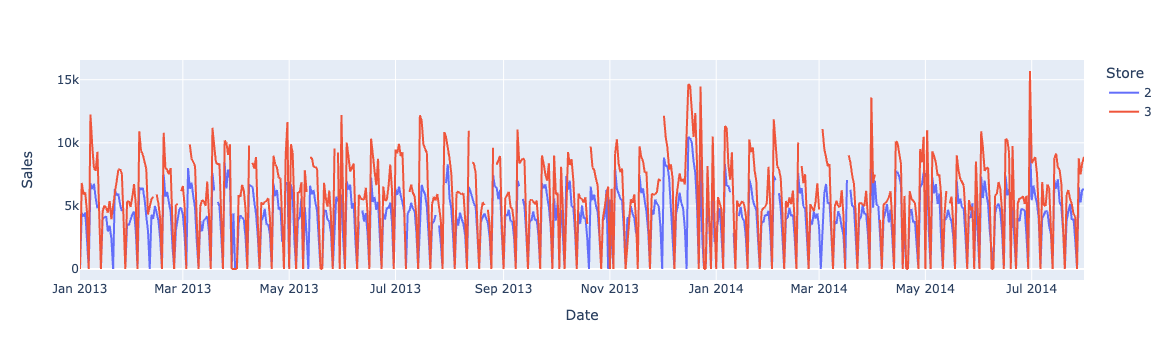

In [10]:

#dt_full.loc[:, "Monday"] = dt_full.loc[:, "DayOfWeek"]==1
shop2 = (dt_full.loc[:, "Store"]==2) | (dt_full.loc[:, "Store"]==3) 
#shop2 = (dt_full.loc[:, "Store"]==3) 

px.line(dt_full[shop2], x="Date", y="Sales",  color='Store')
#px. add_line(dt_full[shop2], x="Date", y="Sales")
#, animation_frame="year", ,size="pop", color="continent", hover_name="country",log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90]

# Feature Engineering

In [11]:
#make one-hot-encoding for the StateHoliday variable
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
dt_eng = dt
dt_eng.loc[: , "PublicHoliday"] = dt.loc[:, "StateHoliday"]=="a" 
dt_eng.loc[: , "Easter"] = dt.loc[:, "StateHoliday"]=="b" 
dt_eng.loc[: , "Christmas"] = dt.loc[:, "StateHoliday"]=="c" 
#dt_eng = dt.drop("StateHoliday", axis=1)


In [12]:
#StoreType One-Hot encoding
dummies = pd.get_dummies(dt.loc[:, "StoreType"], prefix="storetype", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)

In [13]:
#Storetype Mean encoding

#i dont want the 0 sales days (and missing values) have an effect on the averaging... therefore i make a little sz dataframe that drops these values
sz = dt_eng.dropna( how='any', subset=['Sales'])
sales_zeros=(sz["Sales"] == 0)
sz = sz.loc[~sales_zeros, :]

#i use the sz in the groupby
dt_eng = dt_eng.join(sz.groupby("StoreType")["Sales"].mean(), how="left", on="StoreType", rsuffix="_avg_storetype")

In [14]:
#Store Fixed-Effects
#i use the sz again to have the 0 days not affect the mean and median
dt_eng = dt_eng.join(sz.groupby("Store")["Sales"].mean(), how="left", on="Store", rsuffix="_avg_store")
dt_eng = dt_eng.join(sz.groupby("Store")["Sales"].median(), how="left", on="Store", rsuffix="_median_store")

dt_eng.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Open_5',
       'Open_last5', 'Open_10', 'Open_last10', 'Reopening', 'Reopening_big',
       'PublicHoliday', 'Easter', 'Christmas', 'storetype_a', 'storetype_b',
       'storetype_c', 'storetype_d', 'Sales_avg_storetype', 'Sales_avg_store',
       'Sales_median_store'],
      dtype='object')

### Save our mean encodings for the Store_Sales

In [15]:
x = dt_eng.groupby("Store").mean()
x = x.loc[:, "Sales_avg_store"]
data_temp = pd.read_csv("data/store.csv")
data_temp = data_temp.merge(x, how='left', on=None, left_on="Store", right_on=None, left_index=False, right_index=True)
data_temp.to_csv(path_or_buf="data/store_AnSeb.csv")

## go on feature engineering

In [16]:
#Assortment
#dt_eng.groupby("Assortment").mean()['Sales']
dummies = pd.get_dummies(dt_eng.loc[:, "Assortment"], prefix="assort", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)

In [17]:
dt_eng.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Open_5',
       'Open_last5', 'Open_10', 'Open_last10', 'Reopening', 'Reopening_big',
       'PublicHoliday', 'Easter', 'Christmas', 'storetype_a', 'storetype_b',
       'storetype_c', 'storetype_d', 'Sales_avg_storetype', 'Sales_avg_store',
       'Sales_median_store', 'assort_a', 'assort_b', 'assort_c'],
      dtype='object')

### put in interactions

In [18]:
#do different store types react differently to christmas?
#plt.bar(dt_eng["DayOfWeek"], height=dt_eng["Sales"])
#plt.show()

In [19]:
#import plotly.express as px
#fig = px.bar(dt_eng, x='year', y='pop')
#fig.show()

In [20]:
#Storetypes reacting to Christmas
dt_eng.loc[:, "SAXmas"] = dt_eng.storetype_a * dt_eng.Christmas
dt_eng.loc[:, "SBXmas"] = dt_eng.storetype_b * dt_eng.Christmas
dt_eng.loc[:, "SCXmas"] = dt_eng.storetype_c * dt_eng.Christmas
dt_eng.loc[:, "SDXmas"] = dt_eng.storetype_d * dt_eng.Christmas

dt_eng.loc[:, "logDistance"] = np.log(dt_eng.loc[:, "CompetitionDistance"])

## Drop the Sales = 0 (after feature engineering)

In [21]:
dt_eng = dt_eng.dropna( how='any', subset=['Sales'])
sales_zeros=(dt_eng["Sales"] == 0)
dt_eng = dt_eng.loc[~sales_zeros, :]

## Impute some Vaues

In [22]:
#impute the School Holiday
dt_eng["SchoolHoliday"] = dt_eng["SchoolHoliday"].fillna(0)
dt_eng['CompetitionDistance'] = dt_eng['CompetitionDistance'].fillna(dt_eng['CompetitionDistance'].mean())
dt_eng['logDistance'] = dt_eng['logDistance'].fillna(dt_eng['logDistance'].mean())

### time series stuff

In [23]:
#MOVING 7 day average (but i think we will not have this fpr the prediction so i dont use it)
#dt_eng['Sales_MA7'] = 
dt_eng = dt_eng.dropna( how='any', subset=["Store"])
#Moving Average 7 day
#dt_eng['Sales_MA7'] = dt_eng.groupby('Store')['Sales'].transform(lambda x: x.rolling(7, 1).mean())


In [24]:
##Add Monthly Fixed Effects
dt_eng['day'] = pd.DatetimeIndex(dt_eng['Date']).day
dt_eng['month'] = pd.DatetimeIndex(dt_eng['Date']).month
dt_eng['week'] = pd.DatetimeIndex(dt_eng['Date']).week
dt_eng['year'] = pd.DatetimeIndex(dt_eng['Date']).year

<ipython-input-24-907aadee8390>:4: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [25]:
dummies = pd.get_dummies(dt_eng.loc[:, "month"], prefix="m", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)


In [26]:
dt_eng = dt_eng.dropna( how='any', subset=["DayOfWeek"])
dummies = pd.get_dummies(dt_eng.loc[:, "DayOfWeek"].astype(int), prefix="dow", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)

In [27]:
#Beginning of the month craze
dt_eng["monthstart"] = (dt_eng.day>=30) | ( dt_eng.day<=3)

In [28]:
#i want to have a promo counter. i assume that a promo is effective for 1 month (30 days). If a new Promo2 starts, it is set to 30 and then decreases daily
#if the promo is 
store23 = (dt_eng.loc[:, "Store"]==30)

dt_eng["prstart"] = (dt_eng.Promo2SinceWeek <= dt_eng.week) & (dt_eng.Promo2SinceYear <= dt_eng.year)


In [29]:
dt_eng = pd.concat([dt_eng, dt_eng["PromoInterval"].str.split(',', expand=True)], axis=1)

In [30]:
def mnames(s):
    if s=="Jan":
        return 1
    if s=="Feb":
        return 2
    if s=="Mar":
        return 3
    if s=="Apr":
        return 4
    if s=="May":
        return 5
    if s=="Jun":
        return 6
    if s=="Jul":
        return 7
    if s=="Aug":
        return 8
    if s=="Sept":
        return 9
    if s=="Oct":
        return 10
    if s=="Nov":
        return 11
    if s=="Dec":
        return 12

In [31]:
dt_eng.loc[:, 'pr1'] = dt_eng.loc[:, 0].apply(lambda row : mnames(row))
dt_eng.loc[:, 'pr2'] = dt_eng.loc[:, 1].apply(lambda row : mnames(row))
dt_eng.loc[:, 'pr3'] = dt_eng.loc[:, 2].apply(lambda row : mnames(row))
dt_eng.loc[:, 'pr4'] = dt_eng.loc[:, 3].apply(lambda row : mnames(row))

dt_eng.loc[:, "themonth"] = (dt_eng['pr1'] == dt_eng["month"])|(dt_eng['pr2'] == dt_eng["month"])|(dt_eng['pr4'] == dt_eng["month"])|(dt_eng['pr3'] == dt_eng["month"])  
dt_eng["pr_campaign"] = (dt_eng['prstart']==True) & (dt_eng["themonth"] == True)
dt_eng.loc[:, ["month", "pr1", "pr2", "pr3", "pr4", "themonth", "pr_campaign", "prstart"]]                
#dt_eng["pr_campaign"].value_counts()

month  pr1  pr2  pr3   pr4  themonth  pr_campaign  prstart
27          1  2.0  5.0  8.0  11.0     False        False    False
115         1  1.0  4.0  7.0  10.0      True        False    False
147         1  3.0  6.0  9.0  12.0     False        False    False
162         1  NaN  NaN  NaN   NaN     False        False    False
199         1  NaN  NaN  NaN   NaN     False        False    False
...       ...  ...  ...  ...   ...       ...          ...      ...
637768      7  1.0  4.0  7.0  10.0      True         True     True
637769      7  2.0  5.0  8.0  11.0     False        False     True
637771      7  3.0  6.0  9.0  12.0     False        False     True
637772      7  NaN  NaN  NaN   NaN     False        False    False
637773      7  NaN  NaN  NaN   NaN     False        False    False

[482566 rows x 8 columns]

In [32]:
# Make a Variable that counts the days since day 1
dt_eng['Date'] = pd.to_datetime(dt_eng['Date']) 

dt_eng['date_delta'] = (dt_eng['Date'] - dt_eng['Date'].min())  / np.timedelta64(1,'D')
#dt_eng

In [33]:
#Define 'City_Center' =1 if distance <800 & competition open since year <2004
dt_eng['City_center'] = (dt_eng['CompetitionDistance'] < 500) &(dt_eng['CompetitionOpenSinceYear'] < 2004)
dt_eng.City_center.value_counts()

False    475220
True       7346
Name: City_center, dtype: int64

In [34]:
#checkoing the data, one can see that in uneven weeks the first 3 days are selling especially well, this is one way to make it
dt_eng['week1'] = ((dt_eng['week'] % 4) == 0) 
dt_eng['week3'] = ((dt_eng['week'] % 4) == 2)
dt_eng['week13'] = ((dt_eng['week'] % 4) == 0) | ((dt_eng['week'] % 4) == 2)
dt_eng['week13'].value_counts()
dt_eng['firstdaysweek13'] = ((dt_eng['week13']) == True) & (dt_eng['DayOfWeek'] < 4 )

In [35]:
#another way is to code the weekdays separately.... 
dt_eng["Fortnight_Days"] = dt_eng["DayOfWeek"]
dt_eng.Fortnight_Days.value_counts()
dt_eng.loc[dt_eng['week13']==True, "Fortnight_Days"] = dt_eng["Fortnight_Days"] * 2 
dt_eng.Fortnight_Days.value_counts()


4.0     81666
6.0     80508
2.0     80235
12.0    41272
3.0     41082
5.0     40302
10.0    39728
1.0     39261
8.0     36507
14.0     1003
7.0      1002
Name: Fortnight_Days, dtype: int64

## Final Feature selection

In [36]:
dt_eng.columns

Index([                     'Date',                     'Store',
                       'DayOfWeek',                     'Sales',
                            'Open',                     'Promo',
                    'StateHoliday',             'SchoolHoliday',
                       'StoreType',                'Assortment',
             'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',                    'Promo2',
                 'Promo2SinceWeek',           'Promo2SinceYear',
                   'PromoInterval',                    'Open_5',
                      'Open_last5',                   'Open_10',
                     'Open_last10',                 'Reopening',
                   'Reopening_big',             'PublicHoliday',
                          'Easter',                 'Christmas',
                     'storetype_a',               'storetype_b',
                     'storetype_c',               'storetype_d',
             'Sales_avg_s

In [37]:

features = [ 'Open',  'SchoolHoliday', 'CompetitionDistance', 'logDistance', 'prstart', 'Promo2', 'PublicHoliday', 'Easter', 'Christmas' 
            , 'Sales_avg_store', 'storetype_a', 'storetype_b', 'storetype_c', 'storetype_d', 'assort_a', 'assort_b', 'assort_c',
            "monthstart", "date_delta", "City_center", "firstdaysweek13", 
           "m_1","m_12", "DayOfWeek", "Fortnight_Days", 
           "dow_1", "dow_5", "dow_6", "pr_campaign"]
         #   , "Reopening", "Reopening_big"]  "month",'DayOfWeek',"m_2","m_3","m_4","m_5","m_6","m_7","m_8","m_9","m_10","m_11"
          # 'SAXmas','SBXmas','SCXmas','SDXmas'  "Sales_MA7"] "dow_2", "dow_3", "dow_4","dow_7" 

In [38]:
dt_eng[features].isnull().sum()

Open                   0
SchoolHoliday          0
CompetitionDistance    0
logDistance            0
prstart                0
Promo2                 0
PublicHoliday          0
Easter                 0
Christmas              0
Sales_avg_store        0
storetype_a            0
storetype_b            0
storetype_c            0
storetype_d            0
assort_a               0
assort_b               0
assort_c               0
monthstart             0
date_delta             0
City_center            0
firstdaysweek13        0
m_1                    0
m_12                   0
DayOfWeek              0
Fortnight_Days         0
dow_1                  0
dow_5                  0
dow_6                  0
pr_campaign            0
dtype: int64

In [39]:
#dt_eng_nomissing = dt_eng.dropna( how='any', subset=["StateHoliday", "Assortment"])
dt_eng_nomissing = dt_eng.dropna( how='any', subset=features)

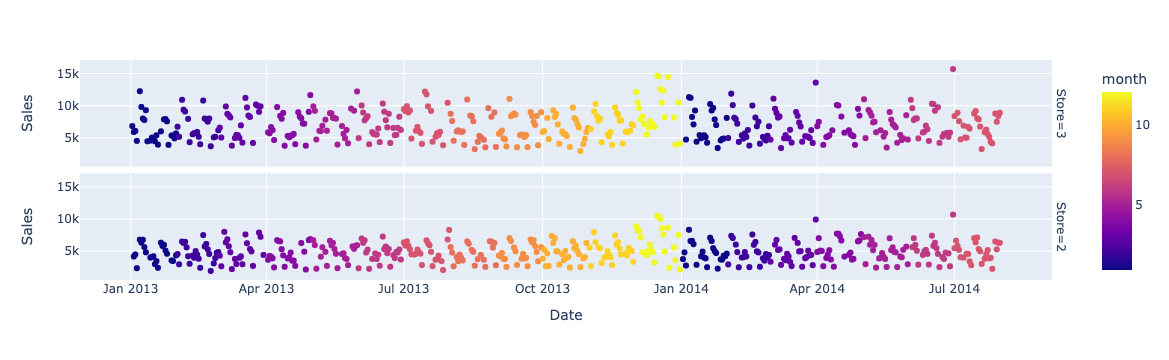

In [41]:
X = dt_eng_nomissing.loc[:, features ]
y = dt_eng_nomissing.loc[:, 'Sales']

In [42]:
#X.isnull().sum()

In [43]:
#import plotly.express as px
#fig = px.scatter(X.loc[:, "DayOfWeek"], y)
#fig.show()

In [44]:
X.count()

Open                   482566
SchoolHoliday          482566
CompetitionDistance    482566
logDistance            482566
prstart                482566
Promo2                 482566
PublicHoliday          482566
Easter                 482566
Christmas              482566
Sales_avg_store        482566
storetype_a            482566
storetype_b            482566
storetype_c            482566
storetype_d            482566
assort_a               482566
assort_b               482566
assort_c               482566
monthstart             482566
date_delta             482566
City_center            482566
firstdaysweek13        482566
m_1                    482566
m_12                   482566
DayOfWeek              482566
Fortnight_Days         482566
dow_1                  482566
dow_5                  482566
dow_6                  482566
pr_campaign            482566
dtype: int64

## Split Data in Test/Train

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, train_size=0.75, random_state=42, shuffle=True, stratify=None)

## Modelling

### Baseline

In [46]:
def rmspe(preds, actuals):
    #preds = preds.reshape(-1)
    #actuals = actuals.reshape(-1)
    #assert preds.shape == actuals.shape
    return np.sqrt(np.mean(np.square((actuals-preds) / actuals))) * 100

In [47]:
#Baseline
dt.loc[:, "Sales"].mean()

5667.469356430033

In [48]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
#pred = lr.predict(X_test)
#actual = y_test
rmspe(lr.predict(X_test), y_test)

31.294867445026348

### Random Forest

In [49]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=10, random_state=42, verbose=1, n_jobs=-1, warm_start=False)
rf.fit(X_train,y_train)

print(f'The RSME is {rmspe(rf.predict(X_test), y_test)}')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


The RSME is 25.307689730624677


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


# Save the Model to disk

In [50]:
#rf.estimators_

In [51]:
# save the model to disk 
pickle.dump(rf, open('model_AnSeb.sav', 'wb'))

In [783]:

error_analysis = X_train
error_analysis.loc[:, "error"] = y_train-rf.predict(X_train)
error_analysis

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    4.8s finished
/Users/selbo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/selbo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Open  SchoolHoliday  CompetitionDistance  logDistance  prstart  \
36576    1.0            0.0                240.0     5.480639    False   
354594   1.0            0.0               2040.0     7.620705    False   
392767   1.0            0.0                330.0     5.799093    False   
461207   1.0            0.0                420.0     6.040255    False   
451911   1.0            0.0                390.0     5.966147    False   
...      ...            ...                  ...          ...      ...   
363387   1.0            0.0               1790.0     7.489971    False   
512703   1.0            0.0              20970.0     9.950848    False   
188624   1.0            0.0                990.0     6.897705    False   
208281   1.0            0.0               2870.0     7.962067    False   
174726   1.0            0.0               2620.0     7.870930    False   

        PublicHoliday  Easter  Christmas  Sales_avg_store  storetype_a  ...  \
36576           False   False      False      8804.199125            0  ...   
354594          False   False      False      6864.424837            1  ...   
392767          False   False      False      8293.685969            1  ...   
461207          False   False      False      9224.395034            1  ...   
451911          False   False      False      9999.671111            1  ...   
...               ...     ...        ...              ...          ...  ...   
363387          False   False      False     15175.673469            1  ...   
512703          False   False      False      8359.305310            0  ...   
188624          False   False      False      3798.259174            1  ...   
208281          False   False      False      8731.818584            0  ...   
174726          False   False      False      7187.423423            0  ...   

        m_11  m_12  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7  \
36576      0     0      0      0      0      0      0      1      0   
354594     1     0      0      0      0      0      1      0      0   
392767     0     1      0      0      0      1      0      0      0   
461207     0     0      0      1      0      0      0      0      0   
451911     0     0      1      0      0      0      0      0      0   
...      ...   ...    ...    ...    ...    ...    ...    ...    ...   
363387     1     0      0      0      0      0      1      0      0   
512703     0     0      0      0      0      0      0      1      0   
188624     0     0      0      0      1      0      0      0      0   
208281     0     0      0      0      0      0      0      1      0   
174726     0     0      0      0      0      1      0      0      0   

             error  
36576   175.600000  
354594 -166.875000  
392767 -466.130000  
461207  121.160000  
451911   38.710000  
...            ...  
363387  -98.370000  
512703  300.840000  
188624  -97.080000  
208281  -91.120000  
174726 -355.425588  

[362071 rows x 40 columns]

In [784]:
error_analysis = pd.merge(error_analysis,dt_eng_nomissing.loc[:, ["Store", "Date"]] , how='left', left_index=True, right_index=True)


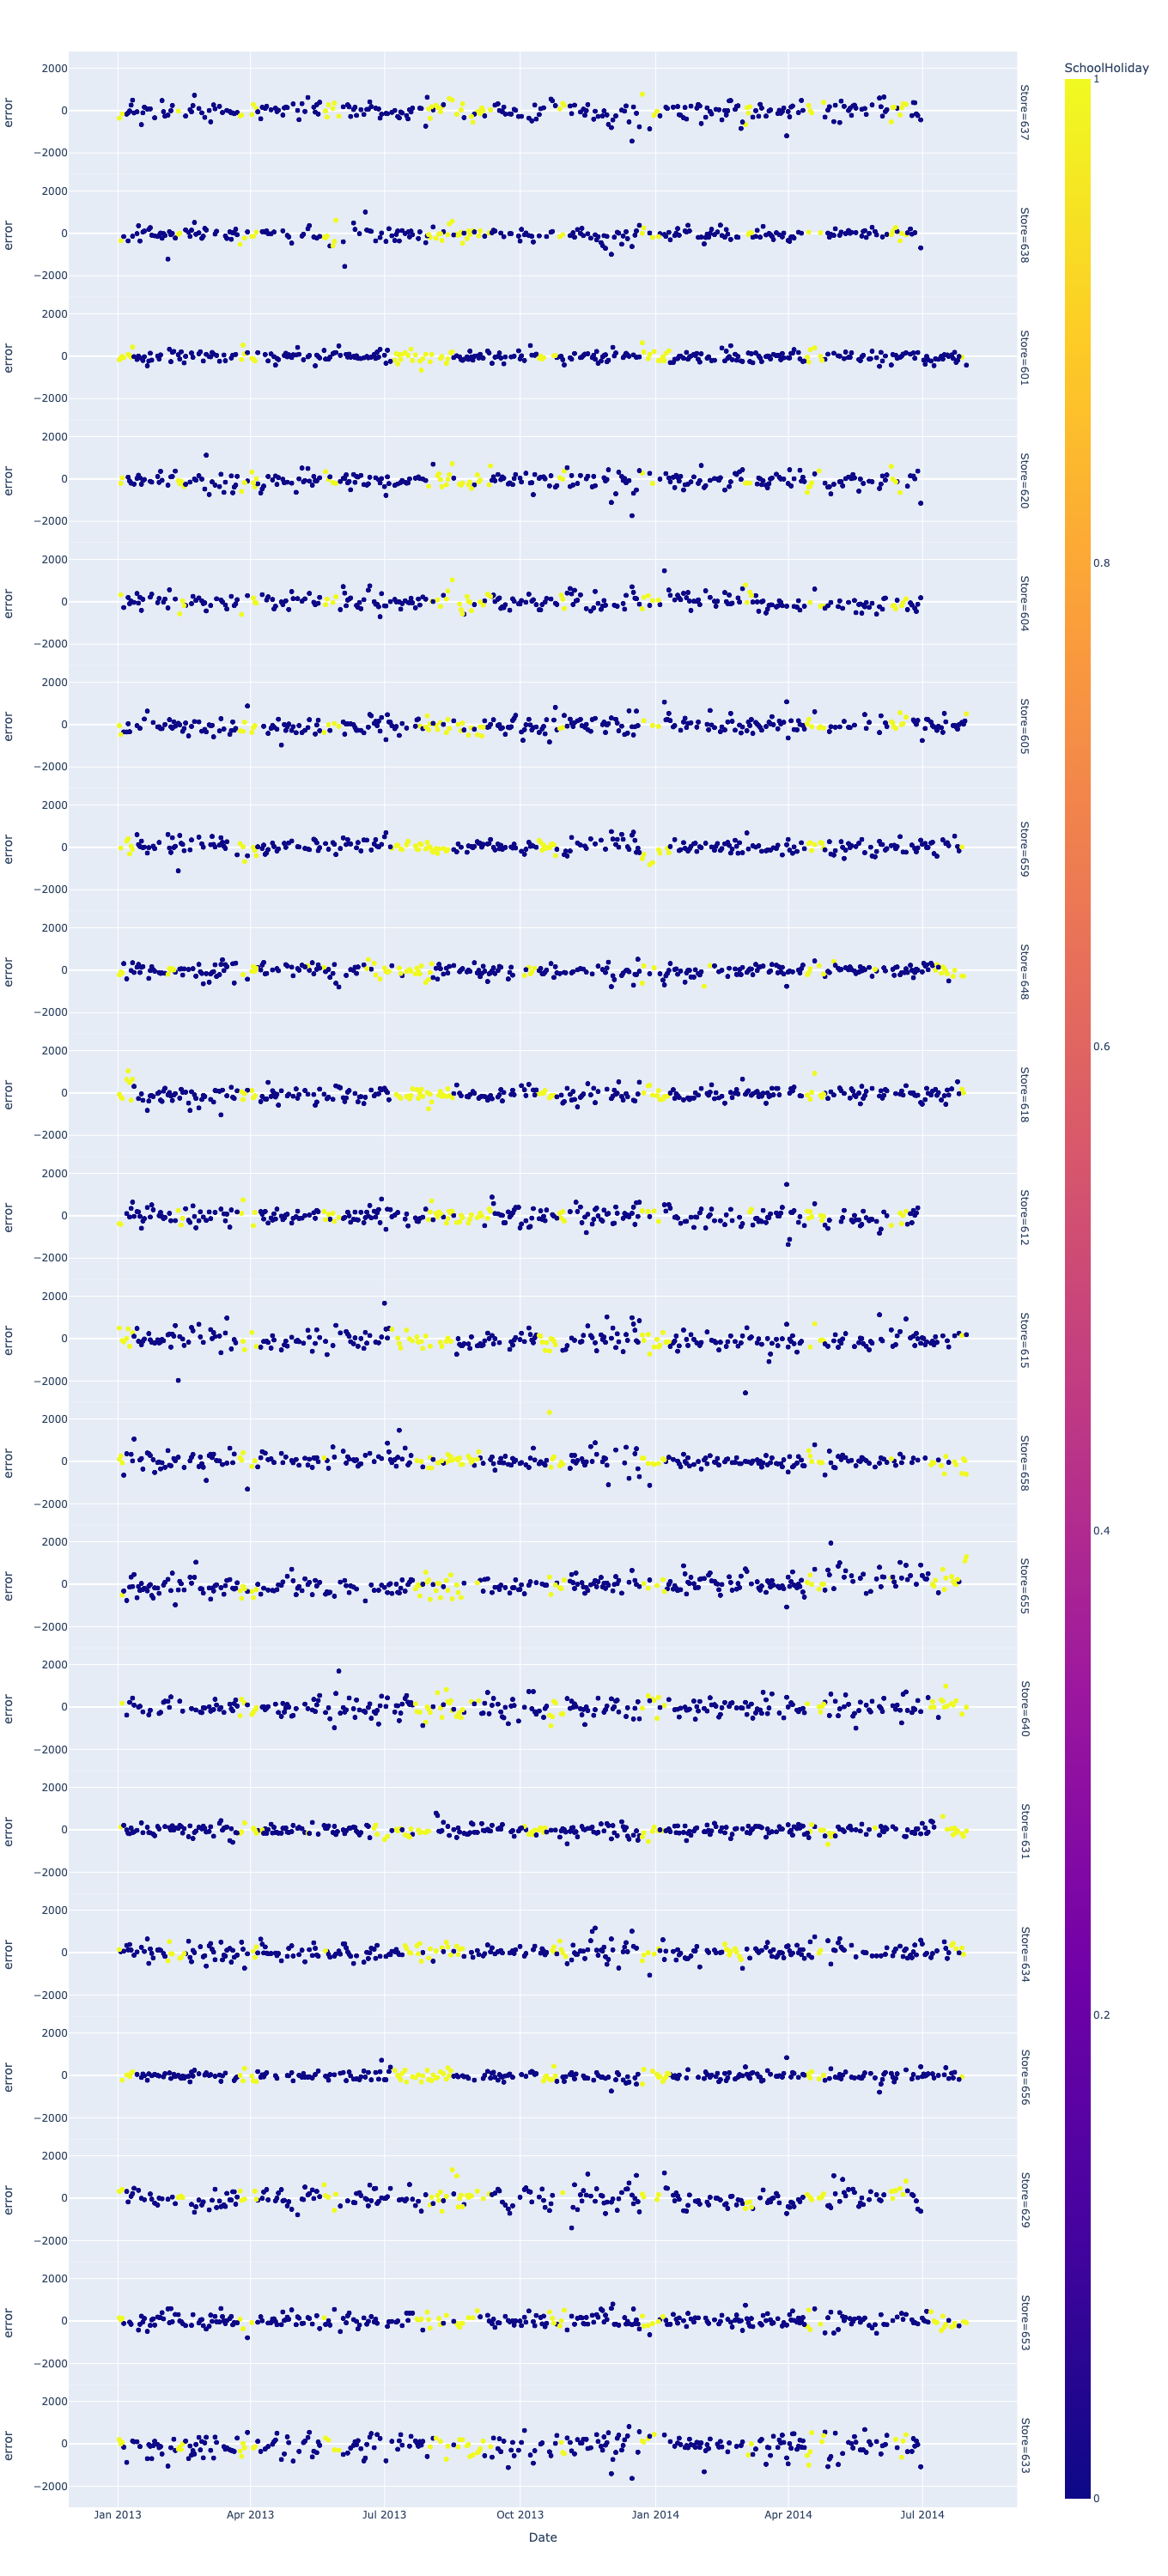

In [787]:
#error_analysis = error_analysis.reset_index()
shop2 = (error_analysis.loc[:, "Store"]>600) & (error_analysis.loc[:, "Store"]<660) & (error_analysis.loc[:, "storetype_d"])
error_analysis.sort_values("Date")
px.scatter(error_analysis[shop2], x="Date", y="error", color="SchoolHoliday", facet_row='Store', height=3000, facet_row_spacing=0.0001)

In [790]:
error_analysis.groupby("CompetitionDistance")['error'].mean()

CompetitionDistance
20.0       10.443382
30.0      -31.023317
40.0      -31.290583
50.0        5.180950
60.0       17.641617
             ...    
45740.0    11.613799
46590.0    -6.005162
48330.0     4.103322
58260.0   -58.497155
75860.0   -64.245914
Name: error, Length: 654, dtype: float64

### XGBoost

In [53]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(max_depth=2,learning_rate=0.1,n_estimators=1000,n_jobs=-1, verbose=3)
xgbr.fit(X_train,y_train)
rmspe( xgbr.predict(X_test), y_test)

[10:31:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




21.610863208992637

## Random Forest tuning

In [380]:
our_range = range(1, 10)
max_depths = our_range
train_results = []
test_results = []
for i in max_depths:
    print(f'Start with maxdepth = {i}')
    rf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=i, random_state=42, verbose=1, n_jobs=-1, warm_start=False)
    rf.fit(X_train,y_train)
    train_results.append(rmspe(rf.predict(X_train), y_train))
    test_results.append(rmspe(rf.predict(X_test), y_test))

Start with maxdepth = 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Start with maxdepth = 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Start with maxdepth = 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Start with maxdepth = 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Start with maxdepth = 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Start with maxdepth = 6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Start with maxdepth = 7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Start with maxdepth = 8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Start with maxdepth = 9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


[50.33181297210201,
 41.72378050103386,
 38.40009006104681,
 37.189732151468306,
 34.63541907262049,
 33.92664049842078,
 31.837504845126496,
 31.594122881334595,
 30.108313420022988]

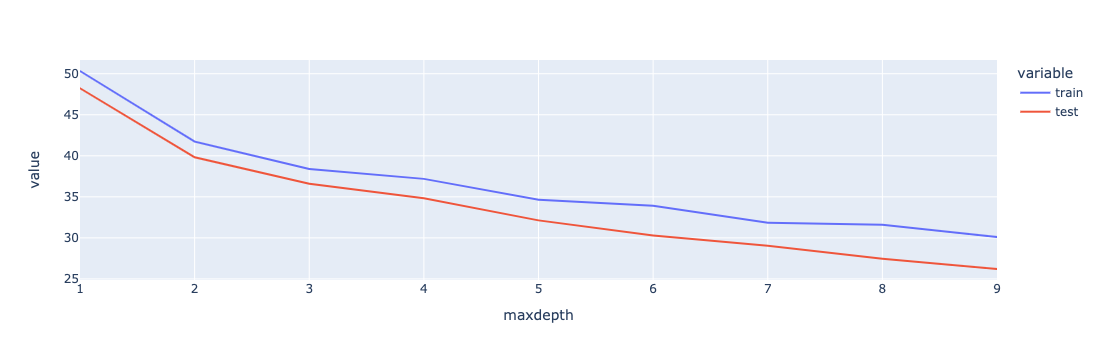

In [384]:
train = pd.DataFrame(train_results, columns=["train"])
test = pd.DataFrame(test_results, columns=["test"])
our_range = pd.DataFrame(our_range, columns=["maxdepth"])
check_depth = pd.concat([our_range, train, test], axis=1)


px.line(check_depth, x="maxdepth", y=["train", "test"])

In [54]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 55, 61, 66, 72, 77, 83, 88, 94, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [55]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 55, 61, 66, 72, 77,
                                                         83, 88, 94, 100]},
                   random_state=42, verbose=1)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    #errors = abs(predictions - test_labels)
    rmspe = rmspe(model.predict(test_features), y_test)

    print('Model Performance')
    print(f'RMSPE: {rmspe:0.4f} degrees.')
    
    return rmspe

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_rmspe = evaluate(base_model, X_train, y_train)

best_random = rf_random.best_estimator_
random_rmspe = evaluate(best_random, X_train, y_train)

print(f'Improvement of {(100 * (random_rmspe - base_rmspe) / base_rmspe):0.2f}%.')

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)


In [ ]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [ ]:
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [1,5,10],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)